<a href="https://colab.research.google.com/github/eftekhar-hossain/Disaster_IEEE-Access/blob/main/damage_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Libraries

In [2]:
%%time
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import re,nltk,json
from sklearn.metrics import confusion_matrix,classification_report 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
from sklearn.metrics import average_precision_score,roc_auc_score, roc_curve, precision_recall_curve
from keras.utils.vis_utils import plot_model
np.random.seed(42)
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import ToktokTokenizer
import string, spacy,unicodedata, random
from bs4 import BeautifulSoup
class color: # Text style
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
import warnings
warnings.filterwarnings('ignore')
### Pretrained Word Embeddings
pretrained_path = "/content/drive/MyDrive/TaheriThesis/Dataset/PreTrained Wordembedding/"
# dataset_path = "/content/drive/MyDrive/Colab Notebooks/MSC Presentation Tasks/Disaster Response/Images/"
# folder_path = "/content/drive/MyDrive/Colab Notebooks/MSC Presentation Tasks/Disaster Response/"
models_path = "/content/drive/MyDrive/TaheriThesis/Dataset/Multimodal Sentiment/"


folder_path = "/content/drive/MyDrive/TaheriThesis/Dataset/"
# models_path = "/content/drive/MyDrive/TaheriThesis/Dataset/Multimodal Sentiment/Models/"
# results_path = "/content/drive/MyDrive/TaheriThesis/Dataset/Multimodal Sentiment/Results/"
dataset_path = "/content/drive/MyDrive/TaheriThesis/Dataset/Images/"


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


CPU times: user 6.18 s, sys: 1.18 s, total: 7.36 s
Wall time: 11.8 s


In [3]:
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense, GlobalAveragePooling2D, Embedding, LSTM, multiply
from keras.models import Model
from keras import preprocessing, Input
from tensorflow import keras
from keras.models import Sequential
#Import from keras_preprocessing not from keras.preprocessing
# from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from tensorflow.keras.models import load_model
import itertools
from PIL import Image, ImageFile
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Concatenate, Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Flatten
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Convolution1D,MaxPooling1D,Conv1D
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.layers import Add, BatchNormalization, Activation, Dropout
from tensorflow.keras.optimizers import RMSprop,Adam,SGD,Nadam
keras.backend.clear_session()

#Fetching Dataset

In [4]:
# train_data = pd.read_excel(folder_path+'train.xlsx')
# test_data = pd.read_csv(folder_path+'test.xlsx')
# valid_data = pd.read_excel(main_path+'valid_new.xlsx')



train_data = pd.read_csv(folder_path+'train.csv')
valid_data = pd.read_csv(folder_path+'val.csv')
test_data = pd.read_csv(folder_path+'test.csv')



In [ ]:
# train_data,test_data  = train_test_split(train_data, random_state=0, train_size = 0.90)

In [ ]:
train_data.columns

Index(['image_name', 'Captions', 'Label_Sentiment', 'Label'], dtype='object')

In [ ]:
train_data['Label'].value_counts()

0    861
6    716
4    623
1    477
5    408
3    400
2    348
Name: Label, dtype: int64

In [ ]:
test_data['Label'].value_counts()

0    91
6    79
4    68
5    46
3    44
1    44
2    40
Name: Label, dtype: int64

In [14]:
# train_data['enc_label'] = train_data['label'].replace({'non_damage':0,'damaged_infrastructure':1,'damaged_nature':2,
#                                                        'fires':3,'flood':4,'human_damage':5 })
# test_data['enc_label'] = test_data['label'].replace({'non_damage':0,'damaged_infrastructure':1,'damaged_nature':2,
#                                                      'fires':3,'flood':4,'human_damage':5 })


train_data['enc_label'] = train_data['Label_Sentiment'].replace({'happy':0,'angry':1,'disgust':2,'fear':3,'sad':4,'surprise':5,'other':6})
valid_data['enc_label'] = valid_data['Label_Sentiment'].replace({'happy':0,'angry':1,'disgust':2,'fear':3,'sad':4,'surprise':5,'other':6})
test_data['enc_label'] = test_data['Label_Sentiment'].replace({'happy':0,'angry':1,'disgust':2,'fear':3,'sad':4,'surprise':5,'other':6})

In [ ]:
print("Size of the training data ==> ", train_data.shape)
print("Size of the Test data ==>", test_data.shape)

Size of the training data ==>  (3833, 5)
Size of the Test data ==> (412, 5)


## Image Fetching

In [5]:
## collect image names from the folders
def create_img_array(img_dirct):
    all_imgs = []
    for root, j, files in os.walk(img_dirct):
        for file in files:
            file = root + '' + file
            all_imgs.append(file)
    return all_imgs

def create_img_path(DF, Col_name, img_dir):
    img_path = [img_dir + '' + name for name in DF[Col_name]]
    return img_path

In [ ]:
# Creating train, test and validation image path
train_img_path = create_img_path(train_data,'image_name', dataset_path)
valid_img_path = create_img_path(valid_data,'image_name', dataset_path)

In [6]:

test_img_path = create_img_path(test_data,'image_name', dataset_path)

In [7]:
# Function that returns image reading from the path
def get_input(path):
    # Loading image from given path
    # and resizing it to 150*150*3 format
    ImageFile.LOAD_TRUNCATED_IMAGES = True
    img= tf.keras.utils.load_img(path, target_size=(150,150)) 
    # img.close()   
    return(img)

# Takes in image and preprocess it
def process_input(img):
    # Converting image to array    
    img_data =tf.keras.utils.img_to_array(img)
    # Adding one more dimension to array    
    img_data = np.expand_dims(img_data, axis=0)
    #     
    img_data = preprocess_input(img_data)
    #img_data = preprocess_input(img_data)
    return(img_data)


In [ ]:
# Create an array of training images
train_images = []
for n,i in enumerate(train_img_path):
  input_img = get_input(i)
  process_img = process_input(input_img)
  # print(n)
  train_images.append(process_img[0])

In [ ]:
# Create an array of training images
valid_images = []
for n,i in enumerate(valid_img_path):
  input_img = get_input(i)
  process_img = process_input(input_img)
  # print(n)
  valid_images.append(process_img[0])

In [ ]:
# Create an array of training images
test_images = []
for n,i in enumerate(test_img_path):
  input_img = get_input(i)
  process_img = process_input(input_img)
  # print(n)
  test_images.append(process_img[0])


In [ ]:
# convert into numpy array
train_image = np.array(train_images)

In [ ]:
valid_image = np.array(valid_images)

In [9]:
test_image = np.array(test_images)

In [ ]:
import pickle as pkl
with open(dataset_path+'train.pkl','wb') as f:
    pkl.dump(train_image, f)

# with open(dataset_path+'test.pkl','wb') as f:
#     pkl.dump(test_image, f)    

In [ ]:
import pickle as pkl
with open(dataset_path+'valid.pkl','wb') as f:
    pkl.dump(valid_image, f)

In [10]:
import pickle as pkl


with open(dataset_path+'test.pkl','wb') as f:
    pkl.dump(test_image, f)  

In [ ]:

with open(dataset_path+'train.pkl','rb') as f:
  train_image = pkl.load(f)
  print("Training Images:-- ",train_image.shape)

Training Images:--  (3833, 150, 150, 3)


In [ ]:

with open(dataset_path+'valid.pkl','rb') as f:
  valid_image = pkl.load(f)
  print("Validation Images:-- ",valid_image.shape)

Validation Images:--  (414, 150, 150, 3)


In [11]:
with open(dataset_path+'test.pkl','rb') as f:
  test_image = pkl.load(f)
  print("Test Images:-- ",test_image.shape)

Test Images:--  (412, 150, 150, 3)


## One Hot Encoding

In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

In [ ]:
# encoder=OneHotEncoder(sparse=False)

# encoded_labels = pd.DataFrame (encoder.fit_transform(train_data[['label']]))

# encoded_labels .columns = encoder.get_feature_names(['label'])

# train_data= pd.concat([train_data, encoded_labels ], axis=1)

import pandas as pd

# Define the list of categories for your Label_Sentiment variable
categories = ['happy', 'angry', 'disgust', 'fear', 'sad', 'surprise', 'other']

# Perform one-hot encoding using get_dummies() function
encoded_labels = pd.get_dummies(train_data['Label_Sentiment'], columns=categories, prefix='Label_Sentiment')

# Concatenate the encoded labels with your original train_data DataFrame
train_data = pd.concat([train_data, encoded_labels], axis=1)

In [ ]:
train_data.columns

Index(['image_name', 'Captions', 'Label_Sentiment', 'Label', 'enc_label',
       'Label_Sentiment_angry', 'Label_Sentiment_disgust',
       'Label_Sentiment_fear', 'Label_Sentiment_happy',
       'Label_Sentiment_other', 'Label_Sentiment_sad',
       'Label_Sentiment_surprise'],
      dtype='object')

In [ ]:
# train_data = train_data.rename(columns={'label_damaged_infrastructure':'damaged_infrastructure', 'label_damaged_nature':'damaged_nature', 
#                                         'label_fires':'fires','label_flood':'flood',
#                                         'label_human_damage':'human_damage', 'label_non_damage':'non_damage'})


train_data = train_data.rename(columns={'Label_Sentiment_happy':'happy', 
                                        'Label_Sentiment_angry':'angry',
                                        'Label_Sentiment_disgust':'disgust',
                                        'Label_Sentiment_fear':'fear',
                                        'Label_Sentiment_sad':'sad',
                                        'Label_Sentiment_surprise':'surprise',
                                        'Label_Sentiment_other':'other'})
     

train_data

image_name                                           Captions  \
0       205.jpg  নির্বোধ দেখার এবং আপনি যে যত্নশীল তা না করার ক...   
1       209.jpg  একটি বোর্ডার আর্ম স্কেটার একটি আমন্ত্রণ উপার্জ...   
2       210.jpg       যদি শরীর দুর্বল হয় তবে মন শক্তিশালী হবে না।   
3       215.jpg  একজন ধার্মিক ব্যক্তির কার্যকর উত্সাহ প্রার্থনা...   
4       222.jpg                                          অসমাপ্ত ?   
...         ...                                                ...   
3828   4676.jpg  অভিনন্দন ২ প্রথম আইবিএম প্যাথওয়েসটেক পণ্ডিতরা...   
3829   4677.jpg  সবেমাত্র আমার চুলের সাথে রুটোশায়ার স্ক্যাল্প ...   
3830   4678.jpg               সবেমাত্র এই ওক ড্রেসারটি শেষ করেছেন।   
3831   4682.jpg  সুগারম্যান রজার্স মামলা-মোকদ্দমা কেমব্রিজে গত ...   
3832   4704.jpg  সন্ত্রাসীদের আতঙ্কিত করা উচিত। কী সেই নাজি প্র...   

     Label_Sentiment  Label  enc_label  angry  disgust  fear  happy  other  \
0              other      6          6      0        0     0      0      1   
1              other      6          6      0        0     0      0      1   
2              other      6          6      0        0     0      0      1   
3              other      6          6      0        0     0      0      1   
4              other      6          6      0        0     0      0      1   
...              ...    ...        ...    ...      ...   ...    ...    ...   
3828           happy      0          0      0        0     0      1      0   
3829           happy      0          0      0        0     0      1      0   
3830           happy      0          0      0        0     0      1      0   
3831           happy      0          0      0        0     0      1      0   
3832           happy      0          0      0        0     0      1      0   

      sad  surprise  
0       0         0  
1       0         0  
2       0         0  
3       0         0  
4       0         0  
...   ...       ...  
3828    0         0  
3829    0         0  
3830    0         0  
3831    0         0  
3832    0         0  

[3833 rows x 12 columns]

In [ ]:
train_data.columns

Index(['image_name', 'Captions', 'Label_Sentiment', 'Label', 'enc_label',
       'angry', 'disgust', 'fear', 'happy', 'other', 'sad', 'surprise'],
      dtype='object')

In [ ]:
train_data.Captions = train_data.Captions.astype(str)

## Text Cleaning

In [ ]:

import locale
print(locale.getpreferredencoding())

import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

UTF-8


In [17]:
!pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 355.8/355.8 kB 14.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.5.0-py2.py3-none-any.whl size=351211 sha256=3afb6152d5fa0a6902a301d13ea986f430a5a4de3df77aec33577981adf5719e
  Stored in directory: /root/.cache/pip/wheels/2a/0c/2c/07b5af72b120503fe24590691d24c462a25e5e530db8700a96
Successfully built emoji


In [12]:
# stp_path = '/content/drive/MyDrive/TaheriThesis/Dataset/'
# stp = open(stp_path+'bangla_stopwords.txt','r',encoding='utf-8').read().split()

In [18]:
'''
Text Cleaning
'''
import emoji
import re

def remove_emojis(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def text_cleaning(row):
   #to remove HTML tags
  text = BeautifulSoup(row, 'html.parser').get_text()
  d = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags=re.MULTILINE) #This line is for removing url
  post = d.replace('\n', '')
  post = d.replace('\r\n', '')
  post = post.replace('—', ' ') 
  post = post.replace('।', ' ')
  text = ''.join([c for c in post if c not in string.punctuation])
  text= remove_emojis(text)
  # to remove special characters
  pattern = r'^\s*|\s\s*'
  text = re.sub(pattern, ' ', text).strip()
  # convert into lower case
  text = text.lower() 
  # # Stopword 
#   result = text.split()
#   text = [word.strip() for word in result if word not in stp ]
#   text =" ".join(text)
  
  return text

In [19]:
#Removing punctuations
train_data['cleaned'] = train_data['Captions'].apply(text_cleaning)
valid_data['cleaned'] = valid_data['Captions'].apply(text_cleaning)
test_data['cleaned'] = test_data['Captions'].apply(text_cleaning)


## Data samples after cleaning
print("Data samples after cleaning:\n")
for i in range(10):
  if i in train_data.index:
    print("Original Data:===\n",train_data.Captions[i],"\nCleaned Data:===\n",train_data.cleaned[i],)

Data samples after cleaning:

Original Data:===
 নির্বোধ দেখার এবং আপনি যে যত্নশীল তা না করার ক্ষমতা আছে 
Cleaned Data:===
 নির্বোধ দেখার এবং আপনি যে যত্নশীল তা না করার ক্ষমতা আছে
Original Data:===
 একটি বোর্ডার আর্ম স্কেটার একটি আমন্ত্রণ উপার্জন করবে? 
Cleaned Data:===
 একটি বোর্ডার আর্ম স্কেটার একটি আমন্ত্রণ উপার্জন করবে
Original Data:===
 যদি শরীর দুর্বল হয় তবে মন শক্তিশালী হবে না। 
Cleaned Data:===
 যদি শরীর দুর্বল হয় তবে মন শক্তিশালী হবে না
Original Data:===
 একজন ধার্মিক ব্যক্তির কার্যকর উত্সাহ প্রার্থনা অনেকটা উপকার পায়। 
Cleaned Data:===
 একজন ধার্মিক ব্যক্তির কার্যকর উত্সাহ প্রার্থনা অনেকটা উপকার পায়
Original Data:===
 অসমাপ্ত ? 
Cleaned Data:===
 অসমাপ্ত
Original Data:===
 আপনাকে পুরো হতে নিখুঁত হতে হবে না! 
Cleaned Data:===
 আপনাকে পুরো হতে নিখুঁত হতে হবে না
Original Data:===
 আজ আমাদের উঠোনে একটি ঠান্ডা, ক্লান্ত, ক্ষুধার্ত, আতঙ্কিত কালো বিড়াল পেয়েছে। সে সেখানে কয়েক দিন ছিল, কেউ তাকে মিস করছে? 
Cleaned Data:===
 আজ আমাদের উঠোনে একটি ঠান্ডা ক্লান্ত ক্ষুধার্ত আতঙ্কিত কা

##Evaluation Metrics

In [20]:
'''Evaluation Parameters'''

def print_metrices(true,pred):
    print(confusion_matrix(true,pred))
    print(classification_report(true,pred))
    print("Accuracy : ",accuracy_score(true,pred))
    print("Precison : ",precision_score(true,pred, average = 'weighted'))
    print("Recall : ",recall_score(true,pred,  average = 'weighted'))
    print("F1 : ",f1_score(true,pred,  average = 'weighted'))

## Confusion Matrix

In [21]:
## Confusion matrix function
def con_mat(true,pred,class_names,model_name):
  cm = confusion_matrix(true,pred)
  #sns.set()
  plt.figure(figsize =(4, 3))
  ax = plt.subplot()
 # 'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds','YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            #'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn'
  sns.heatmap(cm, annot=True,fmt="d",cmap='YlOrRd', ax = ax,annot_kws={"size": 10},) #annot=True to annotate cells
  # labels, title and ticks
  ax.set_xlabel('Predicted labels',fontsize=10)
  ax.set_ylabel('True labels',fontsize=10) 
  #ax.set_title(f'Confusion Matrix of {model_name}',fontsize=10) 
  ax.xaxis.set_ticklabels(class_names, rotation=45); ax.yaxis.set_ticklabels(class_names, rotation=45);
  ax.xaxis.tick_top()
 # plt.savefig(folder_path + f"{model_name}.png",bbox_inches='tight',dpi =500)

In [15]:
from sklearn.utils import compute_class_weight
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_data['enc_label']),
                                        y = train_data['enc_label']                                                   
                                    )
class_weights = dict(zip(np.unique(train_data['enc_label']), class_weights))
class_weights

{0: 0.6359714617554338,
 1: 1.147948487571129,
 2: 1.5734811165845648,
 3: 1.3689285714285715,
 4: 0.881757533931447,
 5: 1.3355400696864113,
 6: 0.7647645650438947}

#Textual Models

## Tokenizer

In [22]:
''' Tokenizer '''

def text_tokenizer(train_data,valid_data,test_data,vocabulary,max_len,sample_text_num):
  
  tokenizer = Tokenizer(num_words = vocabulary ,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n-', 
                        split=' ', char_level=False, oov_token='<oov>', document_count=0)
  tokenizer.fit_on_texts(train_data['cleaned'])  
  word_index = tokenizer.word_index
  vocab_size = len(word_index)+1
  
  # Training Sequences
  train_sequences = tokenizer.texts_to_sequences(train_data['cleaned'])
  train_pad_sequences =  keras.preprocessing.sequence.pad_sequences(train_sequences, value=0.0, padding='post', maxlen= max_len)


  valid_sequences = tokenizer.texts_to_sequences(valid_data['cleaned'])
  valid_pad_sequences =  keras.preprocessing.sequence.pad_sequences(valid_sequences, value=0.0, padding='post', maxlen= max_len)
  
  # Test Sequences
  test_sequences = tokenizer.texts_to_sequences(test_data['cleaned'])
  test_pad_sequences =  keras.preprocessing.sequence.pad_sequences(test_sequences, value=0.0, padding='post', maxlen= max_len)
 

  print(color.BOLD+"\n\t\t\t====== Encoded Sequences ======"+color.END,"\n")  
  print(train_data.cleaned[sample_text_num],"\n",train_sequences[sample_text_num])
  print(color.BOLD+"\n\t\t\t====== Paded Sequences ======\n"+color.END,"\n",train_pad_sequences[sample_text_num]) 

  return train_pad_sequences, valid_pad_sequences, test_pad_sequences, vocab_size, word_index


vocabulary = 50000 
max_len = 180 
sample_text_num = 10

## Call Tokenizer
train_pad_sequences,valid_pad_sequences, test_pad_sequences, vocab_size, word_index =  text_tokenizer(train_data,valid_data,test_data,
                                                                      vocabulary,max_len,sample_text_num) 

print("Number of Train Sequences :" ,train_pad_sequences.shape)
print("Number of Train Sequences :" ,valid_pad_sequences.shape)
print("Number of Test Sequences :" ,test_pad_sequences.shape)
print("Vocabulary Size: ",vocab_size)


			====== Encoded Sequences ====== 

আজ সকালে একটি অন্ধকার লন্ডন কলনিতে আর্সেনালের প্রথম দলের ট্রেন আশা করি আমিরাতরা আগামীকাল হতাশ হবে না 
 [31, 280, 6, 382, 1117, 4136, 4137, 152, 806, 807, 206, 18, 4138, 534, 72, 38, 5]

			====== Paded Sequences ======
 
 [  31  280    6  382 1117 4136 4137  152  806  807  206   18 4138  534
   72   38    5    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0

In [23]:
## Convert labels into array
y_train = np.array(train_data['enc_label']).reshape(-1,1)
y_valid = np.array(valid_data['enc_label']).reshape(-1,1)
y_test = np.array(test_data['enc_label']).reshape(-1,1)

## Callbacks

In [ ]:
''' Callbacks'''
keras.backend.clear_session()
def callbacks_check(model_name):
  num_classes = 7
  accuracy_threshold = 0.99

  class myCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>accuracy_threshold):
          print("\nReached %2.2f%% accuracy so we will stop trianing" % (accuracy_threshold*100))
          self.model.stop_training = True

  acc_callback = myCallback()
  # Saved the Best Model
  filepath = models_path+'Models_3/'+f"{model_name}.h5"
  checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True, 
                                             save_weights_only=False, mode='max')
  # callback list
  callback_list = [acc_callback, checkpoint] 

  return callback_list

## Textual Models (Keras Embeddings)

In [ ]:
def create_keras_embeddings_models(max_len):

  ###### BiLSTM Model #######
  bi_text_inputs = Input(shape=(max_len,))
  bi_embedding_layer = Embedding(vocab_size, 100)(bi_text_inputs)
  LSTM_Layer_1 = Bidirectional(LSTM(128,dropout=0.01))(bi_embedding_layer)
  # bi_dense_layer_1 = Dense(7, activation='softmax')(LSTM_Layer_1)
  bilstm_model = Model(inputs=bi_text_inputs, outputs=LSTM_Layer_1)

  ##### CNN Model  #######
  cnn_text_inputs = Input(shape=(max_len,))
  cnn_embedding_layer = Embedding(vocab_size, 100)(cnn_text_inputs)
  cnn_conv1 = Conv1D(128,2,activation='relu')(cnn_embedding_layer)
  cnn_pool1 = MaxPooling1D(2)(cnn_conv1)
  cnn_flat = Flatten()(cnn_pool1)
  # cnn_dense_layer_1 = Dense(7, activation='softmax')(cnn_flat)
  cnn_model = Model(inputs=cnn_text_inputs, outputs=cnn_flat)


  
  models = [bilstm_model,cnn_model]

  return models

In [24]:
from tensorflow.keras.utils import to_categorical
y_train=to_categorical(train_data['enc_label'])
y_valid=to_categorical(valid_data['enc_label'])
y_test=to_categorical(test_data['enc_label'])

In [ ]:
y_train

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

#Visual Models

In [ ]:
keras.backend.clear_session()

def visual_models():

  # create the base pre-trained model
  vgg = VGG16(weights='imagenet', include_top=False,input_shape=(150, 150, 3))
  for layer in vgg.layers:
      layer.trainable = True
  # add a global spatial average pooling layer
  x = vgg.output
  pool = GlobalAveragePooling2D()(x)
  # let's add a fully-connected layer
  #flat = Flatten()(pool)
  # and a logistic layer -- let's say we have 200 classes
  #hidden1 = Dense(512, activation='relu')(flat)
  #dropout = Dropout(0.1)(hidden1)
  # output = Dense(7, activation='softmax')(pool)
  # this is the model we will train
  vgg_img_model = Model(inputs=vgg.input, outputs=pool)

  #### Resnet
  resnet = ResNet50(weights='imagenet', include_top=False,input_shape=(150, 150, 3))
  #resnet.trainable = False
  for layer in resnet.layers[0:-10]:
      layer.trainable = False
  # add a global spatial average pooling layer
  y = resnet.output
  pool1 = GlobalAveragePooling2D()(y)
  # let's add a fully-connected layer
  #flat1 = Flatten()(pool1)
  # and a logistic layer -- let's say we have 200 classes
  #hidden = Dense(512, activation='relu')(flat1)
  #dropout1 = Dropout(0.1)(hidden)
  # output1 = Dense(7, activation='softmax')(pool1)
  # this is the model we will train
  resnet_img_model = Model(inputs=resnet.input, outputs=pool1)

  models = [vgg_img_model,resnet_img_model]

  return models


In [ ]:
## Inception V3
def inception_model():
# create the base pre-trained model
  inception = keras.applications.InceptionV3(weights='imagenet', include_top=False,input_shape=(150, 150, 3))
  for layer in inception.layers:
    layer.trainable = True
  # add a global spatial average pooling layer
  w = inception.output
  pool = GlobalAveragePooling2D()(w)
  # output = Dense(7, activation='softmax')(pool)
  # this is the model we will train
  inception_img_model = Model(inputs=inception.input, outputs=pool)
  return inception_img_model

## Multimodal Models

In [ ]:
visual_model_name = ['vgg16','resnet']
visual_models_lsit = visual_models()


textual_model_name = ['LSTM','CNN']
text_models_list = create_keras_embeddings_models(180)


94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
for vm,visual_model in enumerate(visual_models_lsit):
  for tm,textual_model in enumerate(text_models_list):
    # Concatenating the output of 2 classifiers
    con_layer = keras.layers.concatenate([visual_model.output, textual_model.output])
    dropout = Dropout(0.2)(con_layer)
    final_dense = Dense(64, activation="relu")(dropout)
    out = Dense(7,activation='softmax')(final_dense)
     
    #Defining model input and output
    com_model = Model(inputs = [visual_model.input, textual_model.input], outputs=out)
    if visual_model == 'vgg16':
      opt = RMSprop()
    else:
      opt = Adam() 
      
    com_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ["accuracy"])
    print(f"Model Name: {visual_model_name[vm]}+{textual_model_name[tm]}\n")
    com_model.fit([train_image,train_pad_sequences],
    y_train,
    epochs=50,
    batch_size =32,
    validation_data=([valid_image,valid_pad_sequences],y_valid),
    verbose =1,
    class_weight = class_weights,
    callbacks = callbacks_check(visual_model_name[vm]+textual_model_name[tm]))

Model Name: vgg16+LSTM

Epoch 1/50
120/120 [==============================] - ETA: 0s - loss: 3.7521 - accuracy: 0.2194
Epoch 1: val_accuracy improved from -inf to 0.34783, saving model to /content/drive/MyDrive/TaheriThesis/Dataset/Multimodal Sentiment/Models_3/vgg16LSTM.h5
120/120 [==============================] - 85s 400ms/step - loss: 3.7521 - accuracy: 0.2194 - val_loss: 1.7081 - val_accuracy: 0.3478
Epoch 2/50
120/120 [==============================] - ETA: 0s - loss: 1.5554 - accuracy: 0.3767
Epoch 2: val_accuracy improved from 0.34783 to 0.58213, saving model to /content/drive/MyDrive/TaheriThesis/Dataset/Multimodal Sentiment/Models_3/vgg16LSTM.h5
120/120 [==============================] - 40s 332ms/step - loss: 1.5554 - accuracy: 0.3767 - val_loss: 1.1305 - val_accuracy: 0.5821
Epoch 3/50
120/120 [==============================] - ETA: 0s - loss: 1.0185 - accuracy: 0.6288
Epoch 3: val_accuracy improved from 0.58213 to 0.69565, saving model to /content/drive/MyDrive/TaheriThes

## Multimodal Models Performance

In [ ]:
multimodal_models = ['vgg16LSTM','vgg16CNN','resnetLSTM','resnetCNN']
multimodal_names =  ['VGG16+LSTM','VGG16+CNNText','ResNet+LSTM','ResNet+CNNText']

def multimodal_models_accuracy(saved_model): 
  my_dict = {}
  # Prediction 
  model = load_model(models_path+'Models_3/'+f"{saved_model}.h5")
  y_pred = np.argmax(model.predict([test_image,test_pad_sequences]), axis=-1)

  y_true = test_data['enc_label']

  my_dict['Accuracy'] = accuracy_score(y_true, y_pred)*100
  my_dict['Precision'] = precision_score(y_true, y_pred,average = 'weighted')*100
  my_dict['Recall'] = recall_score(y_true, y_pred,average = 'weighted')*100 
  my_dict['F1 Score'] = f1_score(y_true, y_pred,average = 'weighted')*100 
  return my_dict

In [ ]:
accuracy = {f'{multimodal_names[i]}':multimodal_models_accuracy(model) for i,model in enumerate(multimodal_models)}
# Save the performance parameter into json file
with open(models_path+'Results_3/'+'multimodal_models_performance.json', 'w') as f:
    json.dump(accuracy, f)

13/13 [==============================] - 2s 54ms/step


In [ ]:
# Load the json file
metrics = json.load(open(models_path+'Results_3/'+'multimodal_models_performance.json'))
acc_list = []
pr_list = []
re_list = []
f1_list = []
for i in metrics.keys():
  acc_list.append(round(metrics[i]['Accuracy'],2))
  pr_list.append(round(metrics[i]['Precision'],2))
  re_list.append(round(metrics[i]['Recall'],2))
  f1_list.append(round(metrics[i]['F1 Score'],2))

print (color.BOLD+f"=======  Multimodal Models Performance on Test Data  =============\n"+color.END)
# Create a dataframe
performance_matrix = pd.DataFrame({'Accuracy':acc_list,'Precision':pr_list,
                                   'Recall':re_list,'F1 Score':f1_list},
                                  index =multimodal_names)
performance_matrix

=======  Multimodal Models Performance on Test Data  =============



Accuracy  Precision  Recall  F1 Score
VGG16+LSTM         75.49      77.42   75.49     75.51
VGG16+CNNText      75.00      76.41   75.00     75.42
ResNet+LSTM        75.73      78.11   75.73     75.88
ResNet+CNNText     74.51      77.23   74.51     74.80

In [ ]:
multimodal_models = ['vgg16LSTM','vgg16CNN','resnetLSTM','resnetCNN']
multimodal_names =  ['VGG16+LSTM','VGG16+CNNText','ResNet+LSTM','ResNet+CNNText']
class_names = ['happy','angry','disgust','fear','sad','surprise','other']
def multimodal_models_metrics(saved_model,model_name): 
   
  model = load_model(models_path+'Models_3/'+f"{saved_model}.h5")
  y_pred = np.argmax(model.predict([test_image,test_pad_sequences]), axis=-1)

  y_true = test_data['enc_label']
  # con_mat(y_true,y_pred,class_names,model_name) 
  print_metrices(y_true,y_pred)

In [ ]:
print (color.BOLD+f"======= Matrices for Visual Models  =============\n"+color.END)
for i,model in enumerate(multimodal_models):
  multimodal_models_metrics(model,multimodal_names[i])

======= Matrices for Visual Models  =============

13/13 [==============================] - 3s 77ms/step
[[78  4  0  1  4  2  2]
 [ 5 29  2  1  4  3  0]
 [ 2  3 28  0  4  2  1]
 [ 1  1  1 35  6  0  0]
 [ 9  1  0  0 55  2  1]
 [ 4  0  0  1  4 37  1]
 [10  3  0  2  7  7 49]]
              precision    recall  f1-score   support

           0       0.72      0.86      0.78        91
           1       0.71      0.66      0.68        44
           2       0.90      0.70      0.79        40
           3       0.88      0.80      0.83        44
           4       0.65      0.81      0.72        68
           5       0.70      0.79      0.74        47
           6       0.91      0.63      0.74        78

    accuracy                           0.75       412
   macro avg       0.78      0.75      0.76       412
weighted avg       0.77      0.75      0.76       412

Accuracy :  0.7548543689320388
Precison :  0.7742309650216672
Recall :  0.7548543689320388
F1 :  0.7551434686358244
13/13 [======

In [ ]:
from sklearn.metrics import matthews_corrcoef

multimodal_models = ['vgg16LSTM','vgg16CNN','resnetLSTM','resnetCNN']
multimodal_names =  ['VGG16+LSTM','VGG16+CNNText','ResNet+LSTM','ResNet+CNNText']
class_names = ['happy', 'angry', 'disgust', 'fear', 'sad', 'surprise', 'other']

def multimodal_models_metrics_MCC(saved_model, model_name):
  model = load_model(models_path + 'Models_3/' + f"{saved_model}.h5")
  y_pred = np.argmax(model.predict(test_pad_sequences), axis=-1)
  y_true = test_data['enc_label']

 

  # Calculate MCC
  mcc = matthews_corrcoef(y_true, y_pred)
  print(f"MCC for {model_name}: {mcc}")

print(f"{color.BOLD}======= Matrices for Visual Models  ============={color.END}")
for i, model in enumerate(multimodal_models):
  multimodal_models_metrics_MCC(model, multimodal_names[i])

======= Matrices for Visual Models  =============
13/13 [==============================] - 2s 80ms/step
MCC for VGG16+LSTM: 0.7114628136986565
13/13 [==============================] - 2s 93ms/step
MCC for VGG16+CNNText: 0.7050737528908579
13/13 [==============================] - 3s 55ms/step
MCC for ResNet+LSTM: 0.7156666849447282
13/13 [==============================] - 2s 56ms/step
MCC for ResNet+CNNText: 0.7005869224024304


## Error Analysis (Quantative)

In [ ]:
multimodal_models = ['vgg16LSTM','vgg16CNN','resnetLSTM','resnetCNN']
multimodal_names =  ['VGG16+LSTM','VGG16+CNNText','ResNet+LSTM','ResNet+CNNText']
class_names = ['happy','angry','disgust','fear','sad','surprise','other']
def models_confusion_matrix(saved_model,model_name): 

  # if saved_model == 'vgg16LSTM':
    # model = visual_models()
    model=load_model(models_path+'Models_3/'+f"{saved_model}.h5")
    y_pred = np.argmax(model.predict([test_image,test_pad_sequences]), axis=-1)

  


    y_true = test_data['enc_label']
    con_mat(y_true,y_pred,class_names,model_name)  





======= Confusion Matrix of best Models  =============

13/13 [==============================] - 2s 56ms/step


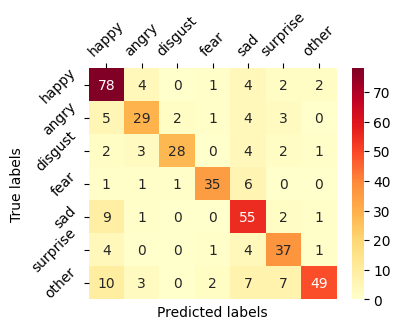

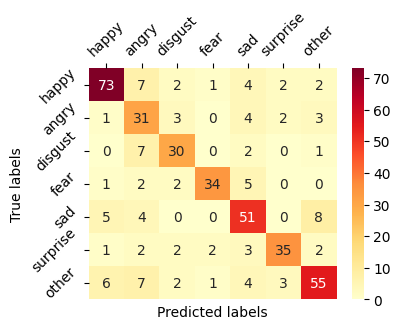

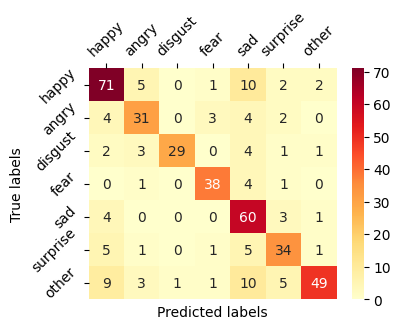

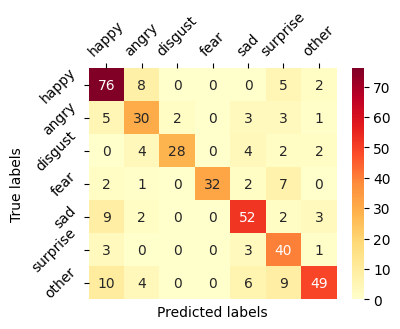

In [ ]:
print (color.BOLD+f"======= Confusion Matrix of best Models  =============\n"+color.END)
for i,model in enumerate(multimodal_models):
    models_confusion_matrix(model,multimodal_names[i])

## Feature Visualization

In [25]:
from keras.utils import to_categorical
y_train=to_categorical(train_data['enc_label'])
y_test=to_categorical(test_data['enc_label'])

In [26]:

# Load the saved model
model=load_model(models_path+'Models_3/'+ 'inceptionLSTM_early.h5') 
y_pred = np.argmax(model.predict([test_image,test_pad_sequences]), axis=-1)

13/13 [==============================] - 10s 583ms/step


In [27]:
model = load_model(models_path+'Models_3/'+ 'inceptionLSTM_early.h5') 
for layer in model.layers:
    print(layer.name, layer.trainable)
    print('Layer Configuration:')
    print(layer.get_config(), end='\n{}\n'.format('----'*10))

input_8 True
Layer Configuration:
{'batch_input_shape': (None, 150, 150, 3), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_8'}
----------------------------------------
conv2d_94 True
Layer Configuration:
{'name': 'conv2d_94', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': (3, 3), 'strides': (2, 2), 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
----------------------------------------
batch_normalization_94 True
Layer Configuration:
{'name': 'batch_normalization_94', 'trainable': True, 'dtype': 'float32', 'axis': ListWrapper([3]), 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'sca

In [28]:
def create_truncated_model(trained_model):
    
    #model = load_model(folder_path+'Models_2/'+'vgg16.h5')
    #
    for i, layer in enumerate(model.layers):
        layer.set_weights(trained_model.layers[i].get_weights())
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

# model = create_lstm_attention_resnet_model()
# model.load_weights(folder_path+'Models_2/'+ 'resnet_lstm_att.h5') 

model = load_model(models_path+'Models_3/'+'inceptionLSTM_early.h5')

truncated_model = create_truncated_model(model)
hidden_features = truncated_model.predict([test_image,test_pad_sequences])

13/13 [==============================] - 9s 573ms/step


In [30]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(n_components=7)
pca_result = pca.fit_transform(hidden_features)
print('Variance PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))
##Variance PCA: 0.993621154832802

#Run T-SNE on the PCA features.
tsne = TSNE(n_components=2, perplexity=20, verbose = 1)
tsne_results_2 = tsne.fit_transform(pca_result)

Variance PCA: 1.0
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 412 samples in 0.001s...
[t-SNE] Computed neighbors for 412 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 412 / 412
[t-SNE] Mean sigma: 0.000011
[t-SNE] KL divergence after 250 iterations with early exaggeration: 43.734200
[t-SNE] KL divergence after 1000 iterations: 0.112382


In [31]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(n_components=7)
pca_result = pca.fit_transform(hidden_features)
print('Variance PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))
##Variance PCA: 0.993621154832802

#Run T-SNE on the PCA features.
tsne = TSNE(n_components=3, perplexity=20, verbose = 1)
tsne_results_3 = tsne.fit_transform(pca_result)

Variance PCA: 1.0
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 412 samples in 0.000s...
[t-SNE] Computed neighbors for 412 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 412 / 412
[t-SNE] Mean sigma: 0.000011
[t-SNE] KL divergence after 250 iterations with early exaggeration: 43.216545
[t-SNE] KL divergence after 1000 iterations: 0.092813


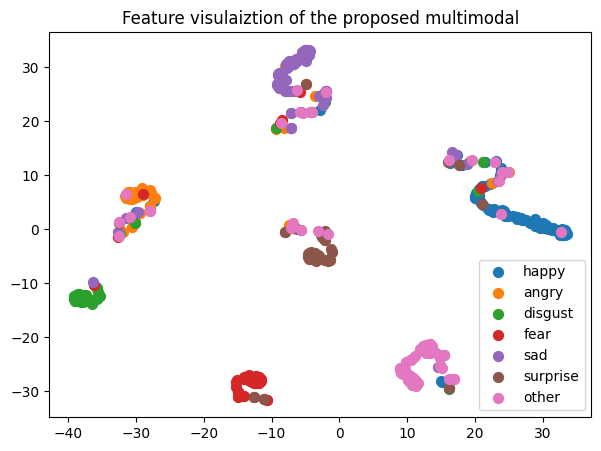

In [32]:
from keras.utils import np_utils
import matplotlib.pyplot as plt
%matplotlib inline

y_test_cat = np_utils.to_categorical(test_data['enc_label'], num_classes = 7)
color_map = np.argmax(y_test_cat, axis=1)
plt.figure(figsize=(7,5))
class_labels = ['happy','angry','disgust','fear','sad','surprise','other']
for i,cl in enumerate(range(7)):
    indices = np.where(color_map==cl)
    indices = indices[0]
    plt.scatter(tsne_results_2[indices,0], tsne_results_2[indices, 1], label=class_labels[i],marker='o',s=50)
plt.title('Feature visulaiztion of the proposed multimodal')    
plt.legend()
plt.savefig(folder_path+'fv.png',dpi = 700,bbox_inches ='tight')
plt.show()



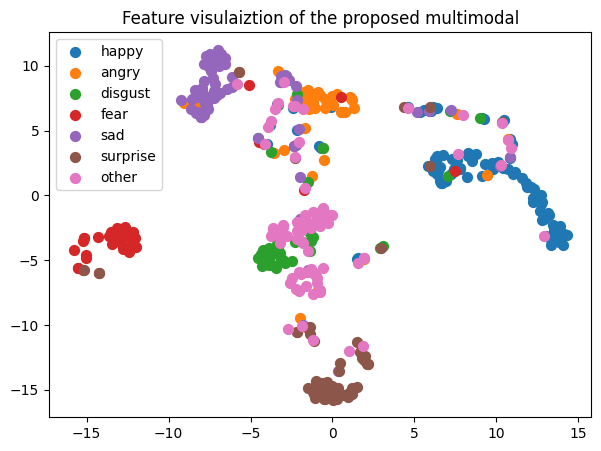

In [33]:
from keras.utils import np_utils
import matplotlib.pyplot as plt
%matplotlib inline

y_test_cat = np_utils.to_categorical(test_data['enc_label'], num_classes = 7)
color_map = np.argmax(y_test_cat, axis=1)
plt.figure(figsize=(7,5))
class_labels = ['happy','angry','disgust','fear','sad','surprise','other']
for i,cl in enumerate(range(7)):
    indices = np.where(color_map==cl)
    indices = indices[0]
    plt.scatter(tsne_results_3[indices,0], tsne_results_3[indices, 1], label=class_labels[i],marker='o',s=50)
plt.title('Feature visulaiztion of the proposed multimodal')    
plt.legend()
plt.savefig(folder_path+'fv3.png',dpi = 700,bbox_inches ='tight')
plt.show()

In [ ]:
### Multimodal models with Inception 

visual_model_name = ['inception']
visual_models_list = [inception_model()]

# textual_model_name = ['LSTM','CNN', 'LSTM-CNN']
textual_model_name = ['LSTM_early','CNN_early']
text_models_list = create_keras_embeddings_models(180)

# keras.backend.clear_session()

# for vm,visual_model in enumerate(visual_models_list):
#   for tm,textual_model in enumerate(text_models_list):
#     # Concatenating the output of 2 classifiers
#     con_layer = keras.layers.concatenate([visual_model.output, textual_model.output])
#     #dropout = Dropout(0.2)(con_layer)
#     #final_dense = Dense(64, activation="relu")(dropout)
#     out = Dense(6,activation='softmax')(con_layer)
     
#     #Defining model input and output
#     com_model = Model(inputs = [visual_model.input, textual_model.input], outputs=out)
      
#     com_model.compile(loss='sparse_categorical_crossentropy', optimizer=RMSprop(), metrics = ["accuracy"])
#     print(f"Model Name: {visual_model_name[vm]}+{textual_model_name[tm]}\n")
#     com_model.fit([train_image,train_pad_sequences],
#     train_data['enc_label'],
#     epochs=50,
#     batch_size =64,
#     validation_split=0.1,
#     verbose =1,
#     callbacks = callbacks_check(visual_model_name[vm] + textual_model_name[tm]))


# visual_model = inception_model()
# textual_model = text_models_list[2]

# # Concatenating the output of 2 classifiers
# con_layer = keras.layers.concatenate([visual_model.output, textual_model.output])
# #dropout = Dropout(0.2)(con_layer)
# #final_dense = Dense(64, activation="relu")(dropout)
# out = Dense(7,activation='softmax')(con_layer)
     
#     #Defining model input and output
# com_model = Model(inputs = [visual_model.input, textual_model.input], outputs=out)
      
# com_model.compile(loss='sparse_categorical_crossentropy', optimizer=RMSprop(), metrics = ["accuracy"])
#     #print(f"Model Name: {visual_model_name[vm]}+{textual_model_name[tm]}\n")
# com_model.fit([train_image,train_pad_sequences],
#   train_data['enc_label'],
#     epochs=50,
#     batch_size =32,
#     validation_data=([valid_image,valid_pad_sequences],y_valid),
#     verbose =1,
#     callbacks = callbacks_check('inception+bilstm-CNN'))





In [ ]:
for vm,visual_model in enumerate(visual_models_list):
  for tm,textual_model in enumerate(text_models_list):
    # Concatenating the output of 2 classifiers
    con_layer = keras.layers.concatenate([visual_model.output, textual_model.output])
    dropout = Dropout(0.2)(con_layer)
    final_dense = Dense(64, activation="relu")(dropout)
    out = Dense(7,activation='softmax')(final_dense)
     
    #Defining model input and output
    com_model = Model(inputs = [visual_model.input, textual_model.input], outputs=out)
    if visual_model == 'vgg16':
      opt = RMSprop()
    else:
      opt = Adam() 
      
    com_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ["accuracy"])
    print(f"Model Name: {visual_model_name[vm]}+{textual_model_name[tm]}\n")
    com_model.fit([train_image,train_pad_sequences],
    y_train,
    epochs=50,
    batch_size =32,
    validation_data=([valid_image,valid_pad_sequences],y_valid),
    verbose =1,
    class_weight = class_weights,
    callbacks = callbacks_check(visual_model_name[vm]+textual_model_name[tm]))

Model Name: inception+LSTM_early

Epoch 1/50
120/120 [==============================] - ETA: 0s - loss: 1.9220 - accuracy: 0.2126
Epoch 1: val_accuracy improved from -inf to 0.21981, saving model to /content/drive/MyDrive/TaheriThesis/Dataset/Multimodal Sentiment/Models_3/inceptionLSTM_early.h5
120/120 [==============================] - 99s 421ms/step - loss: 1.9220 - accuracy: 0.2126 - val_loss: 2.2530 - val_accuracy: 0.2198
Epoch 2/50
120/120 [==============================] - ETA: 0s - loss: 1.6935 - accuracy: 0.3363
Epoch 2: val_accuracy did not improve from 0.21981
120/120 [==============================] - 22s 186ms/step - loss: 1.6935 - accuracy: 0.3363 - val_loss: 2232.3096 - val_accuracy: 0.1691
Epoch 3/50
120/120 [==============================] - ETA: 0s - loss: 1.2126 - accuracy: 0.5171
Epoch 3: val_accuracy improved from 0.21981 to 0.37681, saving model to /content/drive/MyDrive/TaheriThesis/Dataset/Multimodal Sentiment/Models_3/inceptionLSTM_early.h5
120/120 [============

In [ ]:
# multimodal_models = ['inceptionLSTM','inceptionCNN','inceptionLSTM-CNN']
# multimodal_names =  ['inception+LSTM','inception+CNNText','inception+LSTM-CNN']
multimodal_models = ['inceptionLSTM_early','inceptionCNN_early']
multimodal_names =  ['inception+LSTM_early','inception+CNNText_early']

def multimodal_models_accuracy(saved_model): 
  my_dict = {}
  # Prediction 
  model = load_model(models_path+'Models_3/'+f"{saved_model}.h5")
  y_pred = np.argmax(model.predict([test_image,test_pad_sequences]), axis=-1)

  y_true = test_data['enc_label']

  my_dict['Accuracy'] = accuracy_score(y_true, y_pred)*100
  my_dict['Precision'] = precision_score(y_true, y_pred,average = 'weighted')*100
  my_dict['Recall'] = recall_score(y_true, y_pred,average = 'weighted')*100 
  my_dict['F1 Score'] = f1_score(y_true, y_pred,average = 'weighted')*100 
  return my_dict

In [ ]:
accuracy = {f'{multimodal_names[i]}':multimodal_models_accuracy(model) for i,model in enumerate(multimodal_models)}
# Save the performance parameter into json file
with open(models_path+'Results_3/'+'multimodal_models_performance.json', 'w') as f:
    json.dump(accuracy, f)

13/13 [==============================] - 2s 37ms/step


In [ ]:
# Load the json file
metrics = json.load(open(models_path+'Results_3/'+'multimodal_models_performance.json'))
acc_list = []
pr_list = []
re_list = []
f1_list = []
for i in metrics.keys():
  acc_list.append(round(metrics[i]['Accuracy'],2))
  pr_list.append(round(metrics[i]['Precision'],2))
  re_list.append(round(metrics[i]['Recall'],2))
  f1_list.append(round(metrics[i]['F1 Score'],2))

print (color.BOLD+f"=======  Multimodal Models Performance on Test Data  =============\n"+color.END)
# Create a dataframe
performance_matrix = pd.DataFrame({'Accuracy':acc_list,'Precision':pr_list,
                                   'Recall':re_list,'F1 Score':f1_list},
                                  index =multimodal_names)
performance_matrix

=======  Multimodal Models Performance on Test Data  =============



Accuracy  Precision  Recall  F1 Score
inception+LSTM_early        77.43      78.60   77.43     77.50
inception+CNNText_early     75.49      77.97   75.49     75.76

In [ ]:
# models = ['inceptionLSTM','inceptionCNN','inceptionLSTM-CNN']
# model_names = ['inception+LSTM','inception+CNNText','inception+LSTM-CNN']
multimodal_models = ['inceptionLSTM_early','inceptionCNN_early']
multimodal_names =  ['inception+LSTM_early','inception+CNNText_early']
class_names = ['happy','angry','disgust','fear','sad','surprise','other']
def models_confusion_matrix(saved_model,model_name): 

  # if saved_model == 'vgg16LSTM':
    # model = visual_models()
    model=load_model(models_path+'Models_3/'+f"{saved_model}.h5")
    y_pred = np.argmax(model.predict([test_image,test_pad_sequences]), axis=-1)

  


    y_true = test_data['enc_label']
    con_mat(y_true,y_pred,class_names,model_name)  


======= Confusion Matrix of best Models  =============

13/13 [==============================] - 2s 40ms/step


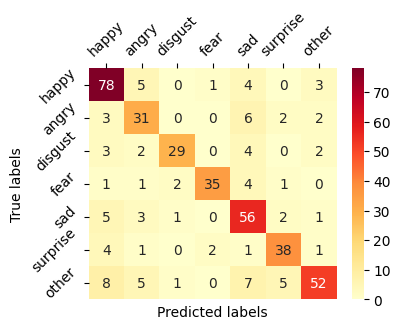

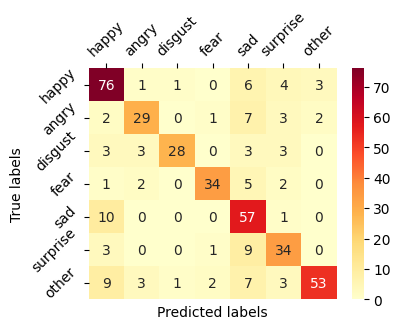

In [ ]:
print (color.BOLD+f"======= Confusion Matrix of best Models  =============\n"+color.END)
for i,model in enumerate(multimodal_models):
    models_confusion_matrix(model,multimodal_names[i])

In [ ]:
multimodal_models = ['inceptionLSTM_early','inceptionCNN_early']
multimodal_names =  ['inception+LSTM_early','inception+CNNText_early']
class_names = ['happy','angry','disgust','fear','sad','surprise','other']
def multimodal_models_metrics(saved_model,model_name): 
   
  model = load_model(models_path+'Models_3/'+f"{saved_model}.h5")
  y_pred = np.argmax(model.predict([test_image,test_pad_sequences]), axis=-1)

  y_true = test_data['enc_label']
  # con_mat(y_true,y_pred,class_names,model_name) 
  print_metrices(y_true,y_pred)

In [ ]:
print (color.BOLD+f"======= Matrices for Visual Models  =============\n"+color.END)
for i,model in enumerate(multimodal_models):
  multimodal_models_metrics(model,multimodal_names[i])

======= Matrices for Visual Models  =============

13/13 [==============================] - 9s 575ms/step
[[78  5  0  1  4  0  3]
 [ 3 31  0  0  6  2  2]
 [ 3  2 29  0  4  0  2]
 [ 1  1  2 35  4  1  0]
 [ 5  3  1  0 56  2  1]
 [ 4  1  0  2  1 38  1]
 [ 8  5  1  0  7  5 52]]
              precision    recall  f1-score   support

           0       0.76      0.86      0.81        91
           1       0.65      0.70      0.67        44
           2       0.88      0.72      0.79        40
           3       0.92      0.80      0.85        44
           4       0.68      0.82      0.75        68
           5       0.79      0.81      0.80        47
           6       0.85      0.67      0.75        78

    accuracy                           0.77       412
   macro avg       0.79      0.77      0.78       412
weighted avg       0.79      0.77      0.77       412

Accuracy :  0.7742718446601942
Precison :  0.785975470640871
Recall :  0.7742718446601942
F1 :  0.774954905702026
13/13 [=======

In [ ]:
from sklearn.metrics import matthews_corrcoef

multimodal_models = ['inceptionLSTM_early','inceptionCNN_early']
multimodal_names =  ['inception+LSTM_early','inception+CNNText_early']
class_names = ['happy', 'angry', 'disgust', 'fear', 'sad', 'surprise', 'other']

def multimodal_models_metrics_MCC(saved_model, model_name):
  model = load_model(models_path + 'Models_3/' + f"{saved_model}.h5")
  y_pred = np.argmax(model.predict([test_image,test_pad_sequences]), axis=-1)
  y_true = test_data['enc_label']

 

  # Calculate MCC
  mcc = matthews_corrcoef(y_true, y_pred)
  print(f"MCC for {model_name}: {mcc}")

print(f"{color.BOLD}======= Matrices for Visual Models  ============={color.END}")
for i, model in enumerate(multimodal_models):
  multimodal_models_metrics_MCC(model, multimodal_names[i])

======= Matrices for Visual Models  =============
13/13 [==============================] - 13s 852ms/step
MCC for inception+LSTM_early: 0.7334470044996766
13/13 [==============================] - 8s 498ms/step
MCC for inception+CNNText_early: 0.7115158547607892


In [ ]:
models = ['keras_LSTM.h5','resnet.h5','inceptionLSTM_early.h5']
model_names = ['Best Textual Model','Best Visual Model','Proposed Model']
class_names = ['happy', 'angry', 'disgust', 'fear', 'sad', 'surprise', 'other']

  # Define a result table as a DataFrame
result_table = pd.DataFrame({'caption':test_data['Captions'],'image':test_data['image_name']})

for i,mn in enumerate(models):
  
  if mn == 'keras_LSTM.h5':
    
    model_t=load_model(models_path+'Models_3/'+mn)
    y_pred = np.argmax(model_t.predict(test_pad_sequences), axis=-1)

  elif mn == 'resnet.h5':  
    model_v = load_model(models_path+'Models_3/'+mn)
    y_pred = np.argmax(model_v.predict(test_image), axis=-1) 

  else:
    
    # model_mm = load_model(models_path+'Models_3/'+mn)
    # y_pred = np.argmax(model_mm.predict([test_image,test_pad_sequences]), axis=-1)

    model = load_model(models_path+'Models_3/inceptionLSTM_early.h5')
    y_pred = np.argmax(model.predict([test_image,test_pad_sequences]), axis=-1)
  
  new_pred = y_pred.astype('uint8')
    
  result_table[model_names[i]] = new_pred
    # Set name of the classifiers as index labels
#result_table.set_index('classifiers', inplace=True)

13/13 [==============================] - 9s 550ms/step


In [ ]:

## Image Display Function
def display_image(image_name):
  from matplotlib import image as im
  data = im.imread(dataset_path+f'{image_name}')
  plt.figure()
  plt.axis('off')
  
  plt.imshow(data)
  plt.savefig(models_path+'Results_3/'+f'{image_name}',bbox_inches ='tight')
  

In [ ]:
labels = ['happy', 'angry', 'disgust', 'fear', 'sad', 'surprise', 'other']

def actual_label(row):
    return labels[row]

result_table['Best Textual Model']= result_table['Best Textual Model'].apply(actual_label)
result_table['Best Visual Model']= result_table['Best Visual Model'].apply(actual_label)
result_table['Proposed Model']= result_table['Proposed Model'].apply(actual_label)
result_table['Actual'] = test_data['enc_label'].apply(actual_label)

In [ ]:

result_table[['Best Textual Model', 'Best Visual Model',
       'Proposed Model', 'Actual']].to_excel(models_path+'results.xlsx',index = False)

In [ ]:
result_table

caption  \
0    প্রথমার্ধ শেষে ফলাফলঃ মরক্কো-০ ফ্রান্স-১\nশেষম...   
1                                          ০১/১২/২২...   
2    হে আল্লাহ\nমাজলুম সকল উলামায়ে কেরামের\nদ্রুত ম...   
3                           এই গরমে যেটা আমি করতে চাই।   
4    আমি হাই স্কুল থেকে আমার পুরানো টুকরা পেয়েছি !...   
..                                                 ...   
407   এমন নিভৃতচারী প্রতিটি ডোনার এক একজন সুপার হিরো ❤   
408                                অফুরন্ত ভালোবাসা 🥰🖤   
409  তাশরিফের ২৪ ঘন্টায় সংগ্রহ এক কোটি টাকার বেশি। ...   
410  আলহামদুলিল্লাহ সিলেটবাসির জন্য\n( ৮৪১৫০) টাকা ...   
411                                     আল্লাহু আকবর❤️   

                                                 image Best Textual Model  \
0    320317202_537621854944168_6032776849847162554_...              other   
1    317322416_1759653367740943_20597234056714050_n...           surprise   
2    289239858_4926163004156714_2236674541218502294...                sad   
3    60339634_3095720303773244_3667926040996478977_...           surprise   
4                                             2386.jpg              happy   
..                                                 ...                ...   
407  289375493_4921221681317513_6416435812427723496...              happy   
408  289191110_4917175091722172_2439210022385464357...              happy   
409  289156396_4926324857473862_2729921420349851184...              happy   
410  289017539_4921398891299792_4839462300728528907...              happy   
411  288960775_4931487560290925_8503372810997772963...              happy   

    Best Visual Model Proposed Model    Actual  
0             disgust          other     other  
1                 sad          happy     other  
2             disgust            sad     other  
3            surprise          angry     other  
4               other       surprise  surprise  
..                ...            ...       ...  
407             happy          happy     happy  
408             happy          happy     happy  
409             happy          happy     happy  
410             happy          happy     happy  
411             happy          happy     happy  

[412 rows x 6 columns]

In [ ]:
result = pd.read_excel(models_path+'results.xlsx')


In [ ]:
print_metrices(result['Actual'],result['Proposed Model'])

[[31  0  0  3  2  6  2]
 [ 2 29  0  3  2  4  0]
 [ 1  2 35  1  0  4  1]
 [ 5  0  1 78  3  4  0]
 [ 5  1  0  8 52  7  5]
 [ 3  1  0  5  1 56  2]
 [ 1  0  2  4  1  1 38]]
              precision    recall  f1-score   support

       angry       0.65      0.70      0.67        44
     disgust       0.88      0.72      0.79        40
        fear       0.92      0.80      0.85        44
       happy       0.76      0.86      0.81        91
       other       0.85      0.67      0.75        78
         sad       0.68      0.82      0.75        68
    surprise       0.79      0.81      0.80        47

    accuracy                           0.77       412
   macro avg       0.79      0.77      0.78       412
weighted avg       0.79      0.77      0.77       412

Accuracy :  0.7742718446601942
Precison :  0.785975470640871
Recall :  0.7742718446601942
F1 :  0.774954905702026


In [ ]:
clf_report = classification_report(result['Actual'],
                                   result['Best Textual Model'],
                                   output_dict=True)

clf_report.pop("accuracy")


clf_report['Happy'] = clf_report.pop('happy')
clf_report['Angry'] = clf_report.pop('angry')
clf_report['Disgust'] = clf_report.pop('disgust')
clf_report['Fear'] = clf_report.pop('fear')
clf_report['Sad'] = clf_report.pop('sad')
clf_report['Surprise'] = clf_report.pop('surprise')
clf_report['Neutral'] = clf_report.pop('other')


clf_report['M. avg'] = clf_report.pop('macro avg')
clf_report['W. avg'] = clf_report.pop('weighted avg')

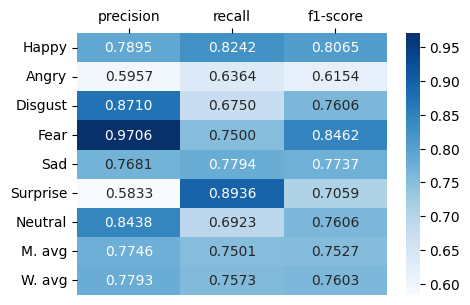

In [ ]:

# .iloc[:-1, :] to exclude support
plt.figure(figsize=(5,3.4))
sns.color_palette()
ax = sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, fmt='.4f',cmap = 'Blues',annot=True)
ax.xaxis.set_ticks_position('top')
plt.savefig(models_path+'cr-textual-2.png',dpi = 500,bbox_inches ='tight')

In [ ]:
clf_report = classification_report(result['Actual'],
                                   result['Best Visual Model'],
                                   output_dict=True)

clf_report.pop("accuracy")


clf_report['Happy'] = clf_report.pop('happy')
clf_report['Angry'] = clf_report.pop('angry')
clf_report['Disgust'] = clf_report.pop('disgust')
clf_report['Fear'] = clf_report.pop('fear')
clf_report['Sad'] = clf_report.pop('sad')
clf_report['Surprise'] = clf_report.pop('surprise')
clf_report['Neutral'] = clf_report.pop('other')


clf_report['M. avg'] = clf_report.pop('macro avg')
clf_report['W. avg'] = clf_report.pop('weighted avg')

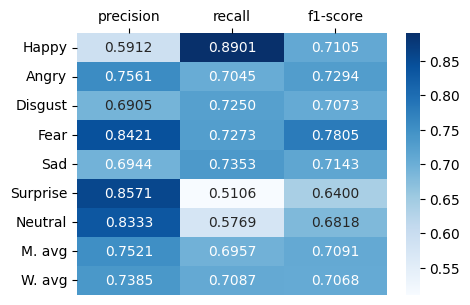

In [ ]:
# .iloc[:-1, :] to exclude support
plt.figure(figsize=(5,3.4))
sns.color_palette()
ax = sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, fmt='.4f',cmap = 'Blues',annot=True)
ax.xaxis.set_ticks_position('top')
plt.savefig(models_path+'cr-textual-2.png',dpi = 500,bbox_inches ='tight')

In [ ]:
clf_report = classification_report(result['Actual'],
                                   result['Proposed Model'],
                                   output_dict=True)

clf_report.pop("accuracy")


clf_report['Happy'] = clf_report.pop('happy')
clf_report['Angry'] = clf_report.pop('angry')
clf_report['Disgust'] = clf_report.pop('disgust')
clf_report['Fear'] = clf_report.pop('fear')
clf_report['Sad'] = clf_report.pop('sad')
clf_report['Surprise'] = clf_report.pop('surprise')
clf_report['Neutral'] = clf_report.pop('other')


clf_report['M. avg'] = clf_report.pop('macro avg')
clf_report['W. avg'] = clf_report.pop('weighted avg')

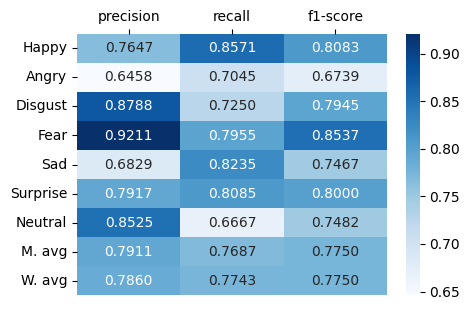

In [ ]:
# .iloc[:-1, :] to exclude support
plt.figure(figsize=(5,3.4))
sns.color_palette()
ax = sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, fmt='.4f',cmap = 'Blues',annot=True)
ax.xaxis.set_ticks_position('top')
plt.savefig(models_path+'cr-textual-2.png',dpi = 500,bbox_inches ='tight')

In [ ]:

# for i in range(len(result_table)):
#     if i!=24 and result_table['Proposed Model'][i] !=result_table['Best Textual Model'][i] and result_table['Proposed Model'][i] !=result_table['Best Visual Model'][i] and result_table['Proposed Model'][i] ==result_table['Actual'][i]:
#         display_image(result_table['image'][i])
#         print('Textual Model ===>',result_table['Best Textual Model'][i],'\n',
#             'Visual Model ===>',result_table['Best Visual Model'][i],'\n',
#             'Proposed Model ===>',result_table['Proposed Model'][i],'\n',
#             'Actual Label ===>',result_table['Actual'][i],'\n',
#             'Caption ===>',result_table['caption'][i],'\n'
#             )
#         print('Image === >\n',i+1)
        


Textual Model ===> disgust 
 Visual Model ===> sad 
 Proposed Model ===> angry 
 Actual Label ===> angry 
 Caption ===> নবীজির সুন্নাহ কে অপমান করা মানে আমার নবীকে অপমান করা।ছাত্রলীগ হোক আর যেই হোক।বিচার হবে একদিন,আল্লাহ সব দেখছেন 

Image === >



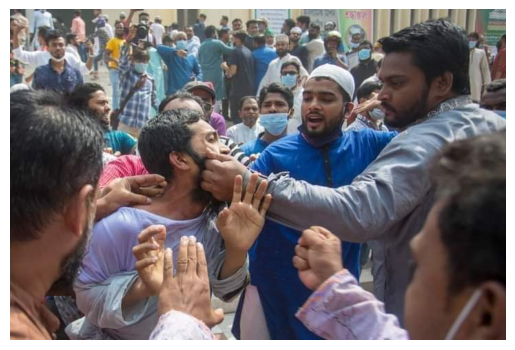

In [ ]:
# Specify the desired index
i = 311


# for i in range(len(result_table)):
#     if i == index:
display_image(result_table['image'][i])
print('Textual Model ===>',result_table['Best Textual Model'][i],'\n',
      'Visual Model ===>',result_table['Best Visual Model'][i],'\n',
      'Proposed Model ===>',result_table['Proposed Model'][i],'\n',
      'Actual Label ===>',result_table['Actual'][i],'\n',
      'Caption ===>',result_table['caption'][i],'\n'
      )
print('Image === >\n',)


Textual Model ===> angry 
 Visual Model ===> angry 
 Proposed Model ===> angry 
 Actual Label ===> angry 
 Caption ===> কিছুদিন আগে দেখলাম বঙ্গবাজারে আগুন লেগেছে এখন দেখছি নিউমার্কের আগুন লেগেছে এটা কি লেগেছে না লাগানো হয়েছে ? সেটাই বুঝতে পারছি না দুইটা অ্যাক্সিডেন্ট কিছুদিনের ভিতরেই ঘটে গেল,, আল্লাহ তুমি সবাইকে হেফাজত করো,,,, 

Image === >



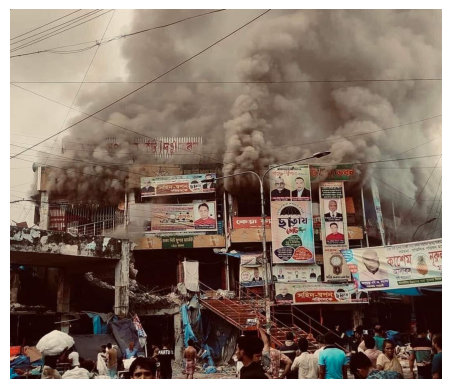

In [ ]:
i = 313


# for i in range(len(result_table)):
#     if i == index:
display_image(result_table['image'][i])
print('Textual Model ===>',result_table['Best Textual Model'][i],'\n',
      'Visual Model ===>',result_table['Best Visual Model'][i],'\n',
      'Proposed Model ===>',result_table['Proposed Model'][i],'\n',
      'Actual Label ===>',result_table['Actual'][i],'\n',
      'Caption ===>',result_table['caption'][i],'\n'
      )
print('Image === >\n',)

Textual Model ===> happy 
 Visual Model ===> happy 
 Proposed Model ===> sad 
 Actual Label ===> sad 
 Caption ===> সবাই বলে: ⬇️⬇️
◾️ "এটা মেসির শেষ বিশ্বকাপ।"
◾️ "এটা রোনালদোর শেষ বিশ্বকাপ।"
◾️ "এটা নেইমারের শেষ বিশ্বকাপ।"
◾️ "এটা মডরিচের শেষ বিশ্বকাপ।"
আমরা সবাই ভুলে যাচ্ছি যে এটি থিয়াগো সিলভারও শেষ বিশ্বকাপ এবং আমরা তার মতো আর একজন খেলোয়াড়কে দীর্ঘকাল খুঁজে পাব না। 😔💔
আমাদের প্রজন্মের অন্যতম সেরা ডিফেন্ডার থিয়াগো সিলভা! 🙌🇧🇷 

Image === >



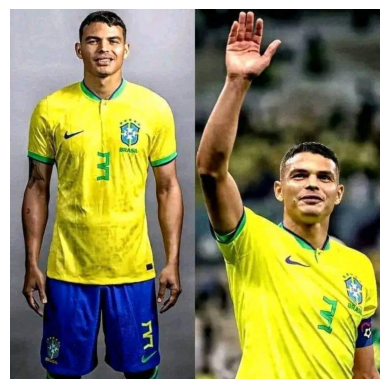

In [ ]:
i = 148


# for i in range(len(result_table)):
#     if i == index:
display_image(result_table['image'][i])
print('Textual Model ===>',result_table['Best Textual Model'][i],'\n',
      'Visual Model ===>',result_table['Best Visual Model'][i],'\n',
      'Proposed Model ===>',result_table['Proposed Model'][i],'\n',
      'Actual Label ===>',result_table['Actual'][i],'\n',
      'Caption ===>',result_table['caption'][i],'\n'
      )
print('Image === >\n',)

Textual Model ===> surprise 
 Visual Model ===> happy 
 Proposed Model ===> sad 
 Actual Label ===> sad 
 Caption ===> ভুল সময়ে জন্ম নেয়া সেরা গোলকিপারদের একজন এডারসন। এলিসন কে জায়গা দিতে ওয়ার্ল্ড কাপের মত মঞ্চে... বেঞ্চে বসে থাকা লাগে। 💔
আমরা আসলেই ভাগ্যবান যে সময়ের দুই সেরা গোলকিপার একসাথে পেয়েছি৷ 🥰 

Image === >



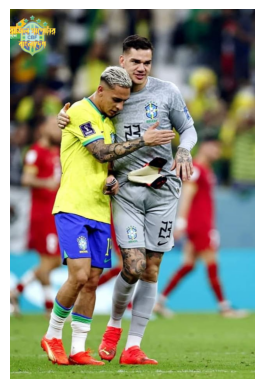

In [ ]:
i = 147


# for i in range(len(result_table)):
#     if i == index:
display_image(result_table['image'][i])
print('Textual Model ===>',result_table['Best Textual Model'][i],'\n',
      'Visual Model ===>',result_table['Best Visual Model'][i],'\n',
      'Proposed Model ===>',result_table['Proposed Model'][i],'\n',
      'Actual Label ===>',result_table['Actual'][i],'\n',
      'Caption ===>',result_table['caption'][i],'\n'
      )
print('Image === >\n',)

Textual Model ===> happy 
 Visual Model ===> sad 
 Proposed Model ===> other 
 Actual Label ===> other 
 Caption ===> আমরা আমাদের গ্রাহকদের কথা শুনি এবং আপনি কী চান তা আমরা জানি 

Image === >



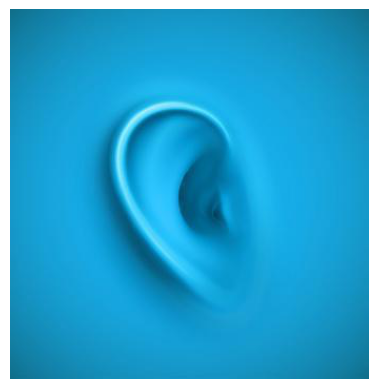

In [ ]:
i = 10


# for i in range(len(result_table)):
#     if i == index:
display_image(result_table['image'][i])
print('Textual Model ===>',result_table['Best Textual Model'][i],'\n',
      'Visual Model ===>',result_table['Best Visual Model'][i],'\n',
      'Proposed Model ===>',result_table['Proposed Model'][i],'\n',
      'Actual Label ===>',result_table['Actual'][i],'\n',
      'Caption ===>',result_table['caption'][i],'\n'
      )
print('Image === >\n',)

Textual Model ===> surprise 
 Visual Model ===> happy 
 Proposed Model ===> surprise 
 Actual Label ===> surprise 
 Caption ===> আশ্চর্যজনকভাবে দেখা যাচ্ছে এস্টার ফুলের একই বৃন্তে দুই রঙের ফুল। 

Image === >



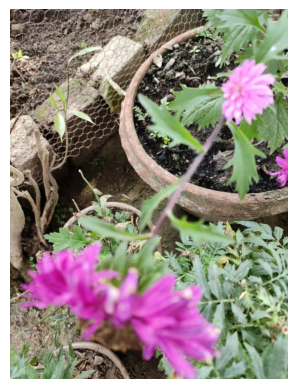

In [ ]:
i = 103


# for i in range(len(result_table)):
#     if i == index:
display_image(result_table['image'][i])
print('Textual Model ===>',result_table['Best Textual Model'][i],'\n',
      'Visual Model ===>',result_table['Best Visual Model'][i],'\n',
      'Proposed Model ===>',result_table['Proposed Model'][i],'\n',
      'Actual Label ===>',result_table['Actual'][i],'\n',
      'Caption ===>',result_table['caption'][i],'\n'
      )
print('Image === >\n',)

Textual Model ===> surprise 
 Visual Model ===> happy 
 Proposed Model ===> fear 
 Actual Label ===> surprise 
 Caption ===> কোন একদিন আমি ঘুম থেকে আর উঠবো না
কিন্তু সেদিনই আশ্চর্যজনকভাবে সবাই আমাকে
ভালোবাসবে 

Image === >



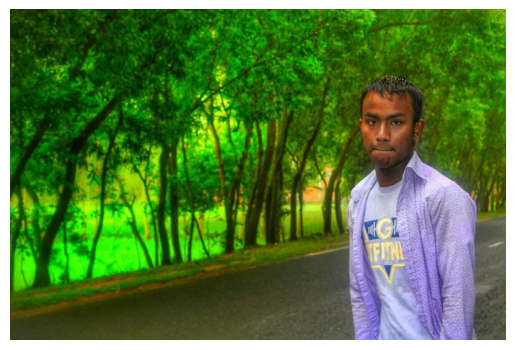

In [ ]:
i = 105


# for i in range(len(result_table)):
#     if i == index:
display_image(result_table['image'][i])
print('Textual Model ===>',result_table['Best Textual Model'][i],'\n',
      'Visual Model ===>',result_table['Best Visual Model'][i],'\n',
      'Proposed Model ===>',result_table['Proposed Model'][i],'\n',
      'Actual Label ===>',result_table['Actual'][i],'\n',
      'Caption ===>',result_table['caption'][i],'\n'
      )
print('Image === >\n',)

Textual Model ===> surprise 
 Visual Model ===> sad 
 Proposed Model ===> surprise 
 Actual Label ===> surprise 
 Caption ===> খুবই আশ্চর্যজনকভাবে প্রকৃতি আলাদা রাখছে হয়ত মমিতাকে আর আমাকে 

Image === >



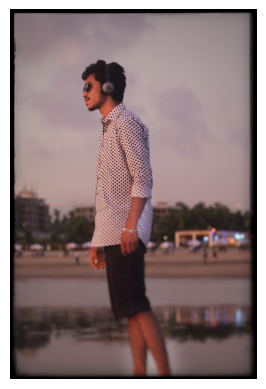

In [ ]:
i = 112


# for i in range(len(result_table)):
#     if i == index:
display_image(result_table['image'][i])
print('Textual Model ===>',result_table['Best Textual Model'][i],'\n',
      'Visual Model ===>',result_table['Best Visual Model'][i],'\n',
      'Proposed Model ===>',result_table['Proposed Model'][i],'\n',
      'Actual Label ===>',result_table['Actual'][i],'\n',
      'Caption ===>',result_table['caption'][i],'\n'
      )
print('Image === >\n',)

Textual Model ===> sad 
 Visual Model ===> fear 
 Proposed Model ===> sad 
 Actual Label ===> sad 
 Caption ===> হারিয়ে যাইনি এটাই জরুরি খবর... 

Image === >



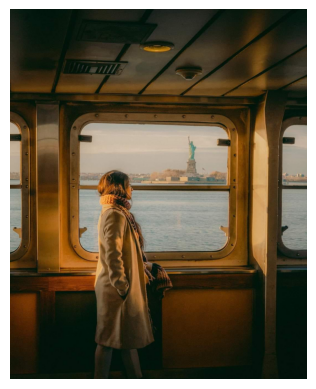

In [ ]:
i = 152


# for i in range(len(result_table)):
#     if i == index:
display_image(result_table['image'][i])
print('Textual Model ===>',result_table['Best Textual Model'][i],'\n',
      'Visual Model ===>',result_table['Best Visual Model'][i],'\n',
      'Proposed Model ===>',result_table['Proposed Model'][i],'\n',
      'Actual Label ===>',result_table['Actual'][i],'\n',
      'Caption ===>',result_table['caption'][i],'\n'
      )
print('Image === >\n',)

Textual Model ===> other 
 Visual Model ===> happy 
 Proposed Model ===> happy 
 Actual Label ===> sad 
 Caption ===> অনুশীলন সময়ে পায়ের গোড়ালি অসুস্থতা বোধ করে লাউতারো মার্টিনেজ,তার পরিবর্তে জুলিয়ান আলভারেজ রাখার চিন্তা করছে লিওনেল স্কোলেনি। 

Image === >



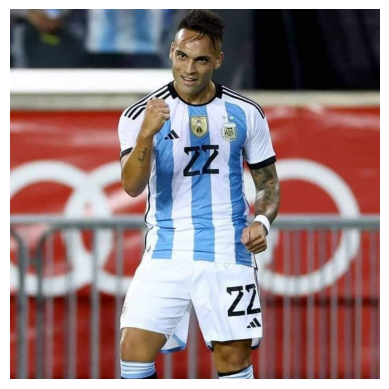

In [ ]:
i =153


# for i in range(len(result_table)):
#     if i == index:
display_image(result_table['image'][i])
print('Textual Model ===>',result_table['Best Textual Model'][i],'\n',
      'Visual Model ===>',result_table['Best Visual Model'][i],'\n',
      'Proposed Model ===>',result_table['Proposed Model'][i],'\n',
      'Actual Label ===>',result_table['Actual'][i],'\n',
      'Caption ===>',result_table['caption'][i],'\n'
      )
print('Image === >\n',)

Textual Model ===> fear 
 Visual Model ===> disgust 
 Proposed Model ===> fear 
 Actual Label ===> fear 
 Caption ===> এসব আবার কি দেখেই ভয় লাগছে 🥶🥶🥶😨 

Image === >



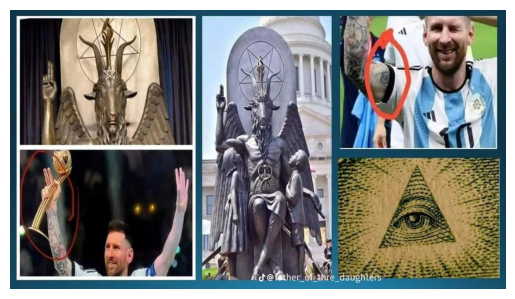

In [ ]:
i = 193


# for i in range(len(result_table)):
#     if i == index:
display_image(result_table['image'][i])
print('Textual Model ===>',result_table['Best Textual Model'][i],'\n',
      'Visual Model ===>',result_table['Best Visual Model'][i],'\n',
      'Proposed Model ===>',result_table['Proposed Model'][i],'\n',
      'Actual Label ===>',result_table['Actual'][i],'\n',
      'Caption ===>',result_table['caption'][i],'\n'
      )
print('Image === >\n',)

Textual Model ===> sad 
 Visual Model ===> other 
 Proposed Model ===> fear 
 Actual Label ===> fear 
 Caption ===> যখন রাত্রি অন্ধকারে ভরা সন্ত্রাস 

Image === >



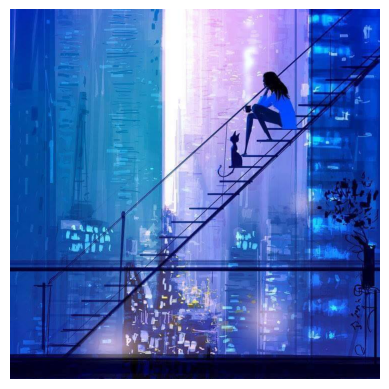

In [ ]:
i = 220


# for i in range(len(result_table)):
#     if i == index:
display_image(result_table['image'][i])
print('Textual Model ===>',result_table['Best Textual Model'][i],'\n',
      'Visual Model ===>',result_table['Best Visual Model'][i],'\n',
      'Proposed Model ===>',result_table['Proposed Model'][i],'\n',
      'Actual Label ===>',result_table['Actual'][i],'\n',
      'Caption ===>',result_table['caption'][i],'\n'
      )
print('Image === >\n',)

Textual Model ===> surprise 
 Visual Model ===> happy 
 Proposed Model ===> sad 
 Actual Label ===> fear 
 Caption ===> জারকা জর্দান-এর বাচ্চাদের কাছ থেকে উত্সাহী হ্যালো-একটি দরিদ্র অঞ্চল যেখানে দেশের অনেক উগ্রপন্থী এসেছেন 

Image === >



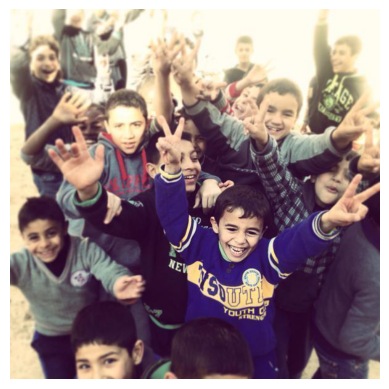

In [ ]:
i = 222


# for i in range(len(result_table)):
#     if i == index:
display_image(result_table['image'][i])
print('Textual Model ===>',result_table['Best Textual Model'][i],'\n',
      'Visual Model ===>',result_table['Best Visual Model'][i],'\n',
      'Proposed Model ===>',result_table['Proposed Model'][i],'\n',
      'Actual Label ===>',result_table['Actual'][i],'\n',
      'Caption ===>',result_table['caption'][i],'\n'
      )
print('Image === >\n',)

Textual Model ===> surprise 
 Visual Model ===> happy 
 Proposed Model ===> happy 
 Actual Label ===> happy 
 Caption ===> গত ২ দিন ধরে সিলেটে আছি আর শহরটির প্রেমে পড়ে গেছি, সুন্দর হয়েছে ❤️
আগামীকাল বিকাল ৪ টায় সিলেটী ভাইদের সাথে দেখা করতে চাই হোটেল স্টার প্যাসিফিক, সিলেট ক্যাফেতে
দেখা হবে 

Image === >



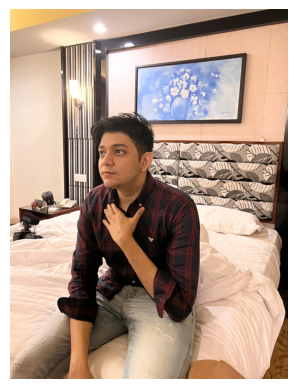

In [ ]:
i = 328


# for i in range(len(result_table)):
#     if i == index:
display_image(result_table['image'][i])
print('Textual Model ===>',result_table['Best Textual Model'][i],'\n',
      'Visual Model ===>',result_table['Best Visual Model'][i],'\n',
      'Proposed Model ===>',result_table['Proposed Model'][i],'\n',
      'Actual Label ===>',result_table['Actual'][i],'\n',
      'Caption ===>',result_table['caption'][i],'\n'
      )
print('Image === >\n',)

Textual Model ===> happy 
 Visual Model ===> happy 
 Proposed Model ===> happy 
 Actual Label ===> happy 
 Caption ===> ২০১০ বিশ্বকাপে ১ বার 🔥
২০১৪ বিশ্বকাপে ৪ বার🔥
২০১৮ বিশ্বকাপে ১ বার🔥
২০২২ বিশ্বকাপে ৪ বার (এখন অবদি)🔥
Leo Messi একমাত্র প্লেয়ার ১০ বার "Man Of The Match" এওয়ার্ড জিতেছেন বিশ্ব আসরে!🔥❤️❤️
🔹◽🔹 

Image === >



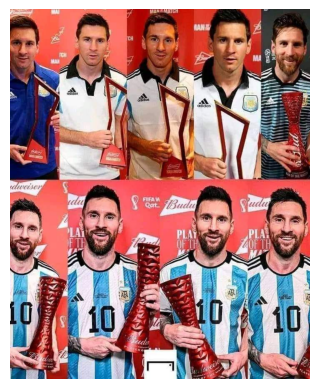

In [ ]:
i = 337


# for i in range(len(result_table)):
#     if i == index:
display_image(result_table['image'][i])
print('Textual Model ===>',result_table['Best Textual Model'][i],'\n',
      'Visual Model ===>',result_table['Best Visual Model'][i],'\n',
      'Proposed Model ===>',result_table['Proposed Model'][i],'\n',
      'Actual Label ===>',result_table['Actual'][i],'\n',
      'Caption ===>',result_table['caption'][i],'\n'
      )
print('Image === >\n',)

Textual Model ===> surprise 
 Visual Model ===> happy 
 Proposed Model ===> happy 
 Actual Label ===> happy 
 Caption ===> হুটহাট আমাদের কেরা উঠা....এদিক ওদিক দৌড় দেওয়া ❤❤❤ 

Image === >



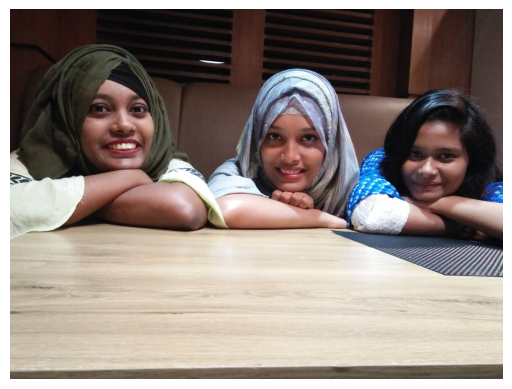

In [ ]:
i = 326


# for i in range(len(result_table)):
#     if i == index:
display_image(result_table['image'][i])
print('Textual Model ===>',result_table['Best Textual Model'][i],'\n',
      'Visual Model ===>',result_table['Best Visual Model'][i],'\n',
      'Proposed Model ===>',result_table['Proposed Model'][i],'\n',
      'Actual Label ===>',result_table['Actual'][i],'\n',
      'Caption ===>',result_table['caption'][i],'\n'
      )
print('Image === >\n',)

Textual Model ===> surprise 
 Visual Model ===> disgust 
 Proposed Model ===> sad 
 Actual Label ===> disgust 
 Caption ===> একদিকে ১৫ কোটি টাকা খরচ করে কনসার্ট করে, অন্য দিকে মানুষ খাদ্যের জন্য টিসিবির গাড়ির পিছনে লাইন ধরে।
স্বাধীনতার ৫০ বছরে স্বাধ নিচ্ছে মানুষ। 

Image === >



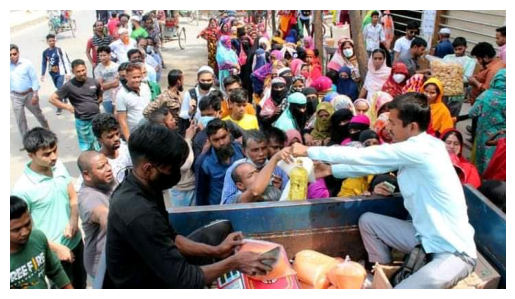

In [ ]:
i = 241


# for i in range(len(result_table)):
#     if i == index:
display_image(result_table['image'][i])
print('Textual Model ===>',result_table['Best Textual Model'][i],'\n',
      'Visual Model ===>',result_table['Best Visual Model'][i],'\n',
      'Proposed Model ===>',result_table['Proposed Model'][i],'\n',
      'Actual Label ===>',result_table['Actual'][i],'\n',
      'Caption ===>',result_table['caption'][i],'\n'
      )
print('Image === >\n',)

Textual Model ===> disgust 
 Visual Model ===> angry 
 Proposed Model ===> disgust 
 Actual Label ===> disgust 
 Caption ===> পরম ব্যাঙ্গর থেকে দুটি গাড়ি অপমান করে কেবল সেখানে দাঁড়িয়ে থাকা ঘর। খুব বিরক্তিকর 

Image === >



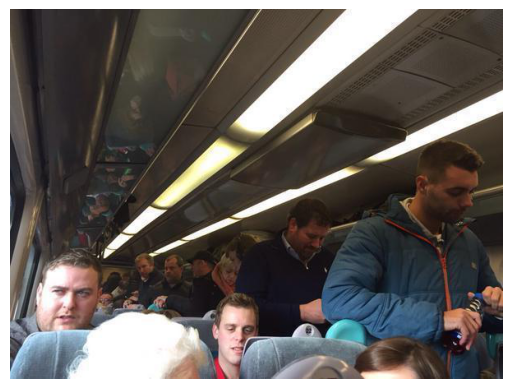

In [ ]:
i = 257


# for i in range(len(result_table)):
#     if i == index:
display_image(result_table['image'][i])
print('Textual Model ===>',result_table['Best Textual Model'][i],'\n',
      'Visual Model ===>',result_table['Best Visual Model'][i],'\n',
      'Proposed Model ===>',result_table['Proposed Model'][i],'\n',
      'Actual Label ===>',result_table['Actual'][i],'\n',
      'Caption ===>',result_table['caption'][i],'\n'
      )
print('Image === >\n',)

Textual Model ===> disgust 
 Visual Model ===> happy 
 Proposed Model ===> disgust 
 Actual Label ===> disgust 
 Caption ===> পাগল? সে মিথ্যা বলেনি। এটি বিরক্তিকর :/ 

Image === >



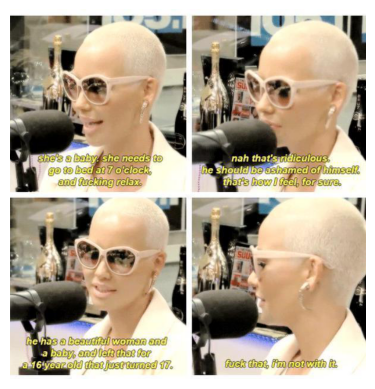

In [ ]:
i = 258


# for i in range(len(result_table)):
#     if i == index:
display_image(result_table['image'][i])
print('Textual Model ===>',result_table['Best Textual Model'][i],'\n',
      'Visual Model ===>',result_table['Best Visual Model'][i],'\n',
      'Proposed Model ===>',result_table['Proposed Model'][i],'\n',
      'Actual Label ===>',result_table['Actual'][i],'\n',
      'Caption ===>',result_table['caption'][i],'\n'
      )
print('Image === >\n',)

Textual Model ===> disgust 
 Visual Model ===> angry 
 Proposed Model ===> angry 
 Actual Label ===> angry 
 Caption ===> একটা পাবলিক ভার্সিটিতে এসে লাইভ রিপোর্টিং করতেছে, কিন্তু নামটাও ঠিকমত বলতে পারে না!😡
"চট্টগ্রাম প্রকৌশল ও প্রযুক্তি বিশ্ববিদ্যালয়" এর জায়গায় "চট্টগ্রাম বিজ্ঞান ও প্রযুক্তি বিশ্ববিদ্যালয়" লিখছে,ঠ্যাংয়ের নাম লিখছে! অশিক্ষিত,মূর্খ সময় টিভি ৷😠 

Image === >



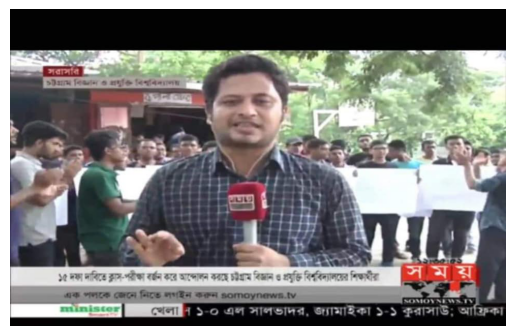

In [ ]:
i = 277


# for i in range(len(result_table)):
#     if i == index:
display_image(result_table['image'][i])
print('Textual Model ===>',result_table['Best Textual Model'][i],'\n',
      'Visual Model ===>',result_table['Best Visual Model'][i],'\n',
      'Proposed Model ===>',result_table['Proposed Model'][i],'\n',
      'Actual Label ===>',result_table['Actual'][i],'\n',
      'Caption ===>',result_table['caption'][i],'\n'
      )
print('Image === >\n',)